In [1]:
#@ Downloading necessary data:
import os
if not os.path.exists('dataset1'):
  !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
  !unzip -q dataset1.zip
  !rm dataset1.zip
  !pip install -q torch_snippets pytorch_model_summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 96.6 MB/s eta 0:00:00


In [2]:
#@ Importing necessaries dependencies:
import torch
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch import nn
device ='cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import Dataset, DataLoader
import cv2
from torch import optim

In [3]:
#@ function for image transformation:
tfms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) # accord to imagenet dataset
])

In [25]:
#@ Fetching input and output images for training:
class SegData(Dataset):
  def __init__(self, split):
    self.items=stems(f'dataset1/images_prepped_{split}')
    self.split=split

  def __len__(self):
    return len(self.items)

  def __getitem__(self, ix):
     # Check if the file exists before trying to read it
        image_path = f'dataset1/images_prepped_{self.split}/{self.items[ix]}'
        if not os.path.exists(image_path):
            print(f"Warning: Image file not found: {image_path}")
            # Handle the missing file (e.g., return a default image, skip the item)
            return None  # Or raise an exception, depending on your desired behavior

         # Add a check to handle potential None values:
        if data is None:
            print(f"Warning: Data is None for index {index}. Skipping this data point.")
            return None # Alternatively, you could raise an exception or handle it differently.


        image = read(image_path, 1)
        image = cv2.resize(image, (224, 224))
        mask = read(image_path)[:, :, 0]
        return image, mask

  # random image index for debugging purpose:
  def choose(self):
    return self[randint(len(self))]

  def collate_fn(self, batch):
     # Filter out None values from the batch
        batch = [item for item in batch if item is not None]

        # If the batch is now empty, handle it appropriately
        if not batch:
            print("Warning: Batch is empty after filtering None values. Returning empty tensors.")
            return torch.empty((0)), torch.empty((0)) # Or handle it differently as needed

        ims, masks=list(zip(*batch))
        ims=torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_mask=torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_mask

In [26]:
#@ training and valid dataset:
train_ds=SegData('train')
valid_ds=SegData('test')
trn_dl=DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=train_ds.collate_fn)
val_dl=DataLoader(valid_ds, batch_size=1, shuffle=True, collate_fn=valid_ds.collate_fn)


##### Architecture for image segmentation

In [27]:
#@ defining convolution blocks:
def conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

In [28]:
#@ defining Up-Convolution:
def up_conv(in_channels, out_channels):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2), # ensure image upscaling
      nn.ReLU(inplace=True)
  )

In [29]:
#@ Defining Network Class:
from torchvision.models import vgg16_bn # for large scale
class UNet(nn.Module):
  def __init__(self, pretrained=True, out_channels=12):
    super().__init__()
    self.encoder=vgg16_bn(pretrained=pretrained).features # excluding FC at end

    # encoder blocks
    self.block1=nn.Sequential(*self.encoder[:6])
    self.block2=nn.Sequential(*self.encoder[6:13])
    self.block3=nn.Sequential(*self.encoder[13:20])
    self.block4=nn.Sequential(*self.encoder[20:27])
    self.block5=nn.Sequential(*self.encoder[27:34])

    self.bottleneck=nn.Sequential(*self.encoder[34:]) #acts between encoder and decoder
    self.conv_bottleneck=conv(512, 1024)

    self.up_conv6=up_conv(1024, 512)
    self.conv6=conv(512 + 512, 512)
    self.up_conv7=up_conv(512, 256)
    self.conv7=conv(512 + 256, 256)
    self.up_conv8=up_conv(256, 128)
    self.conv8=conv(128 + 256, 128)
    self.up_conv9=up_conv(128, 64)
    self.conv9=conv(128 + 64, 64)
    self.up_conv10=up_conv(64, 32)
    self.conv10=conv(32 + 64, 32)

    self.conv11=nn.Conv2d(32, out_channels, kernel_size=1)

  def forward(self, x):
    block1=self.block1(x)
    block2=self.block2(block1)
    block3=self.block2(block2)
    block4=self.block2(block3)
    block5=self.block2(block4)

    bottleneck=self.bottleneck(block5)
    x=self.conv_bottleneck(bottleneck)

    x=self.up_conv6(x)
    x=torch.cat([x, block5], dim=1)
    x=self.conv6(x)

    x=self.up_conv7(x)
    x=torch.cat([x, block4], dim=1)
    x=self.conv7(x)

    x=self.up_conv8(x)
    x=torch.cat([x, block3], dim=1)
    x=self.conv8(x)

    x=self.up_conv9(x)
    x=torch.cat([x, block2], dim=1)
    x=self.conv9(x)


    x=self.up_conv10(x)
    x=torch.cat([x, block1], dim=1)
    x=self.conv10(x)

    x=self.conv11(x)

    return x


In [30]:
#@ Loss function:
ce=nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
  ce_loss=ce(preds, targets)
  acc=(torch.max(preds, 1)==targets).float().mean()
  return ce_loss, acc

In [31]:
#@ batch training:
def train_batch(model, data, optimizer, criterion):
  model.train()
  ims, ce_masks=data
  _masks=model(ims)
  optimizer.zero_grad()
  loss, acc=criterion(_masks, ce_masks)
  loss.backward()
  optimizer.step()
  return loss.item(), acc.item()

In [32]:
#@ validation:

@torch.no_grad()
def valid_batch(model, data, criterion):
  model.eval()
  ims, masks=data
  _masks=model(ims)
  loss, acc=criterion(_masks, masks)
  return loss.item(), acc.item()

model=UNet().to(device)
criterion=UnetLoss
optimizer=optim.Adam(model.parameters(), lr=1e-3)
n_epochs=20

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
import time
import matplotlib.pyplot as plt
from collections import defaultdict

class Report:
    def __init__(self, n_epochs):
        self.n_epochs = n_epochs
        self.metrics = defaultdict(list)
        self.start_time = None
        self.epoch_start_time = None

    def record(self, position, **kwargs):
        # Record each metric (e.g., trn_loss, val_loss, etc.) at the given position
        for key, value in kwargs.items():
            self.metrics[key].append((position, value))

        # Display the metrics in real-time
        print(f"\rEPOCH: {position:.3f}", end='')
        for key, value in kwargs.items():
            print(f"\t{key}: {value:.3f}", end='')

        # Time calculation and display
        if position == 1:
            self.start_time = time.time()
            self.epoch_start_time = self.start_time
        elif isinstance(position, int):  # at the end of each epoch
            elapsed = time.time() - self.start_time
            avg_time_per_epoch = elapsed / position
            remaining = (self.n_epochs - position) * avg_time_per_epoch
            print(f"\t({elapsed:.2f}s elapsed - {remaining:.2f}s remaining)", end='')
        print(end='\r')

    def report_avgs(self, epoch):
        print(f"\nEPOCH {epoch} AVERAGES", end='')
        avg_metrics = {}

        # Calculate and display average metrics for the epoch
        for key in self.metrics:
            values = [value for pos, value in self.metrics[key] if int(pos) == epoch]
            avg_metrics[key] = sum(values) / len(values) if values else 0.0
            print(f"\t{key}: {avg_metrics[key]:.3f}", end='')

        # Display final elapsed and remaining time
        elapsed = time.time() - self.start_time
        remaining = (self.n_epochs - epoch) * (elapsed / epoch)
        print(f"\t({elapsed:.2f}s elapsed - {remaining:.2f}s remaining)")

    def plot_epochs(self, metric_names=None):
        # Prepare the data for plotting selected metrics
        plt.figure(figsize=(10, 5))
        for key in self.metrics:
            if metric_names and not any(name in key for name in metric_names):
                continue
            # Extract positions and values for each metric
            positions, values = zip(*self.metrics[key])
            epoch_positions = [int(pos) for pos in positions]
            avg_values_per_epoch = [sum(value for pos, value in self.metrics[key] if int(pos) == ep) /
                                    len([v for p, v in self.metrics[key] if int(p) == ep])
                                    for ep in range(1, self.n_epochs + 1)]
            plt.plot(range(1, self.n_epochs + 1), avg_values_per_epoch, label=key)

        plt.xlabel("Epochs")
        plt.ylabel("Metric Value")
        plt.legend()
        plt.title("Training/Validation Metrics Over Epochs")
        plt.show()

    def plot(self, metric_names=None):
        # Plot batch-level metrics (might be messy for large datasets)
        plt.figure(figsize=(10, 5))
        for key in self.metrics:
            if metric_names and not any(name in key for name in metric_names):
                continue
            # Extract positions and values for each metric
            positions, values = zip(*self.metrics[key])
            plt.plot(positions, values, label=key)

        plt.xlabel("Position (Epoch + Batch)")
        plt.ylabel("Metric Value")
        plt.legend()
        plt.title("Batch Metrics Over Training")
        plt.show()


In [34]:
#@ training model over increasing epochs:
log=Report(n_epochs)
for ex in range(n_epochs):
  N=len(trn_dl)
  for bx, data in enumerate(trn_dl):
    loss, acc=train_batch(model, data, optimizer, criterion)
    log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

  N=len(val_dl)
  for bx, data in enumerate(val_dl):
    loss, acc=valid_batch(model, data, criterion)
    log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

  log.report_avgs(ex+1)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [0]

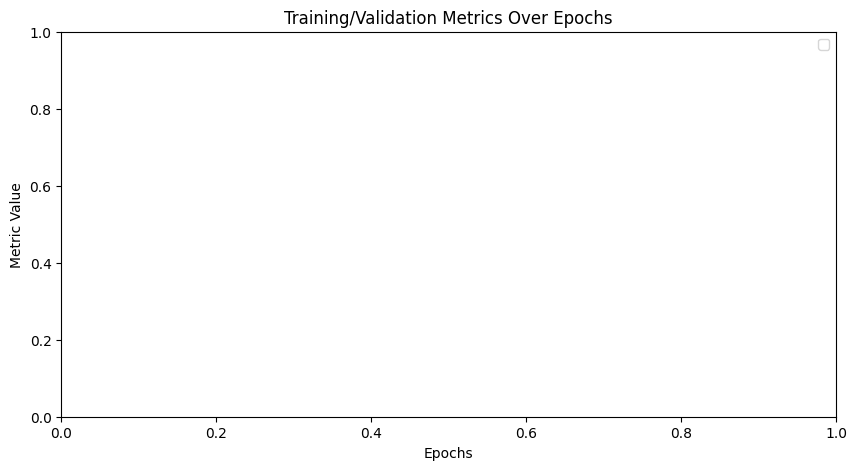

In [14]:
log.plot_epochs(['trn_loss','val_loss'])